<a id='0'></a>
# Описание проекта

Спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.    
*F1-мера должна быть не менее 0.6.*

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Описание данных
В распоряжении исторические данные о поведении клиентов и расторжении договоров с банком. 

**Признаки**   
`RowNumber` — индекс строки в данных  
`CustomerId` — уникальный идентификатор клиента  
`Surname` — фамилия  
`CreditScore` — кредитный рейтинг  
`Geography` — страна проживания  
`Gender` — пол   
`Age` — возраст  
`Tenure` — количество недвижимости у клиента  
`Balance` — баланс на счёте   
`NumOfProducts` — количество продуктов банка, используемых клиентом   
`HasCrCard` — наличие кредитной карты  
`IsActiveMember` — активность клиента  
`EstimatedSalary` — предполагаемая зарплата  

**Целевой признак**    
`Exited` — факт ухода клиента  

# План выполнения проекта
1. [Подготовка данных](#1)
   - Исследование баланса классов
   - Обучение моделей без учета дисбаланса
   - Выводы
2. [Исследование](#2) 
   - Исследование нескольких способов борьбы с дисбалансом
   - Выводы
3. [Выбор модели](#3)  
4. [Тестирование модели](#4)   

<a id='1'></a>
# 1. Подготовка данных

[в начало](#0)

### Импорт библиотек

In [1]:
import os
from urllib.request import urlretrieve

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.utils import shuffle

### Функции

Загрузка файла

In [ ]:
def get_file(file_name, url):
    if not os.path.exists(file_name):
        print('Файл не найден и будет загружен из сети.')
        file_name, headers = urlretrieve(url)
    return pd.read_csv(file_name)

Отрисовка графиков

In [2]:
# confusion matrix graphic
def show_cm(model, features, target):
    '''
    function takes trained model as a parameter and return graphic of confusion_matrix
    '''
    cm = confusion_matrix(target, model.predict(features))
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow((cm))
    ax.xaxis.set(ticks=(0,1), ticklabels=('Predicted 0', 'Predicted Exit'))
    ax.yaxis.set(ticks=(0,1), ticklabels=('Actual 0', 'Actual Exit'))
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', color='red', size='xx-large')
    
    plt.show()

Вывод результата

In [3]:
# check model f1, ROC-AUC scores
def print_score(model, name, features, target, class_weight=None):
    '''return metrics f1 and AUC-ROC for model
    '''
    ml = model(random_state=rs, class_weight=class_weight)
    ml.fit(features, target)
    predicted = ml.predict(features_valid)

    print(name+':')
    print('F1-score: {:.3f}, AUC-ROC: {:.2f}'.format(f1_score(target_valid, predicted),
                                                 roc_auc_score(target_valid, predicted)))

# find best parameters with GridSearchCV
def print_GridSearchCV(model, params, features, target, class_weight=None):
    '''prints best parameteres of the model for scores: 'f1', 'roc_auc'.
    '''
    scoring = ['f1', 'roc_auc']
    
    for score in scoring:
        LR_grid = GridSearchCV(model(random_state=rs, class_weight=class_weight), 
                               params, scoring=score, cv=5)
        LR_grid.fit(features, target)
        print('best parameter: {} {}: {:.2f}'.format(LR_grid.best_params_, score, LR_grid.best_score_))

upsampling и downsampling

In [4]:
def upsampling(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones]*repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones]*repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=rs)
    
    return features_upsampled, target_upsampled

def downsampling(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=rs)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=rs)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=rs)
    
    return features_downsampled, target_downsampled

## Обзор данных

In [5]:
file_name = 'bank_churn.csv'
url = 'https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling?select=Churn_Modelling.csv'

get_file(file_name, url)

data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


## Обработка данных

- Проверим данные на пропуски

In [6]:
print('Пропусков:',data.isnull().sum())

Пропусков: 909


Пропуски есть только в стобце `Tenure`. Так как, многие модели плохо работают с пропусками, то необходимо их обработать. Предположим, что пропуски говорят об отсутствие имущества и заменим на нули.

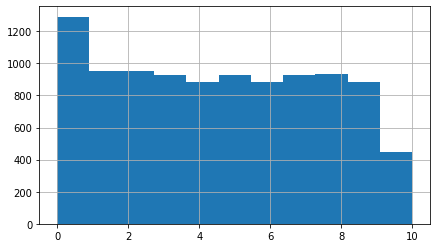

In [7]:
data = data.fillna(0)
data['Tenure'].hist(bins=11, figsize=(7,4))

In [8]:
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

- Проверим данные на дубликаты

In [9]:
data.duplicated().sum()

0

- Проверим данные на артефакты

In [10]:
for i in ['Gender', 'Geography']:
    print()
    print(i)
    print(data[i].value_counts())


Gender
Male      5457
Female    4543
Name: Gender, dtype: int64

Geography
France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64


- Изменим тип данных

In [11]:
for column in ['Tenure', 'Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']:
    data[column] = data[column].astype('int8')
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                   int8
Tenure                int8
Balance            float64
NumOfProducts         int8
HasCrCard             int8
IsActiveMember        int8
EstimatedSalary    float64
Exited                int8
dtype: object

- Удалим признаки, которые не повлияеют на целевой: `RowNumber`, `CustomerId`, `Surname`.

In [12]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

- Посмотрим есть ли явные выбросы

In [13]:
columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']
data.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

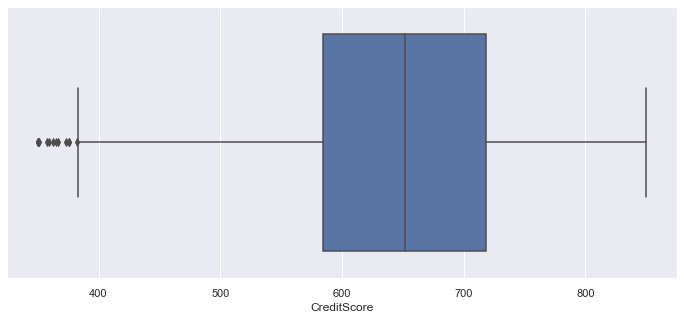

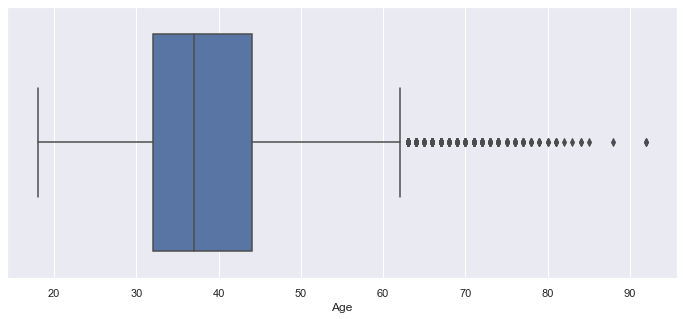

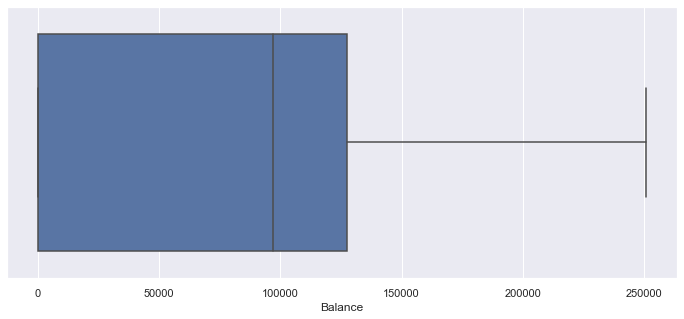

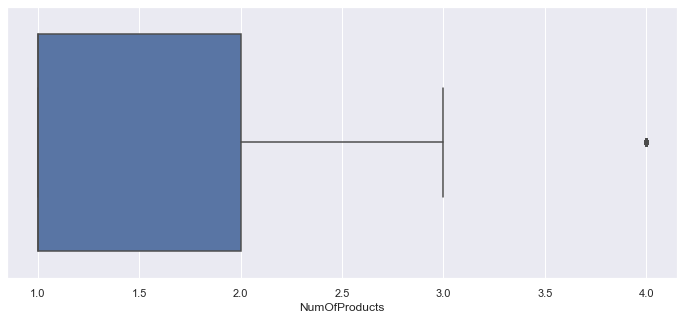

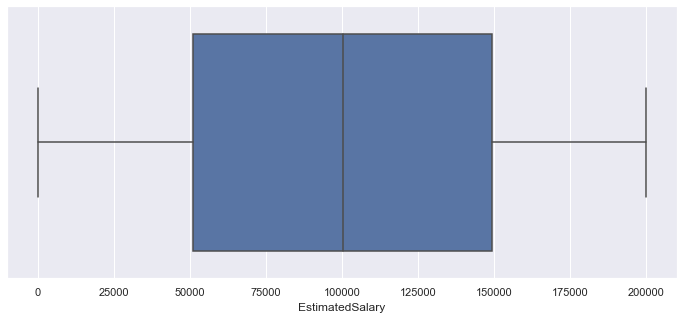

In [14]:
sns.set(rc={'figure.figsize':(12,5)})
for i in columns:
    sns.boxplot(data[i])
    plt.show()

Явных выбросов не обнаружено. 
Мало клиентов имеет кредитный рейтинг менее 400, что возможно.   
Большая часть клиентов в возрасте от 18 до 62, максимальный возраст 92, тоже логично.

### Анализ мультиколлинеарности факторов

In [15]:
data.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,0.003087,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.007368,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.003087,-0.007368,1.000000,-0.005821,0.010106,0.021387,-0.025856,0.011225,-0.013319
Balance,0.006268,0.028308,-0.005821,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.010106,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.021387,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.025856,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.011225,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.013319,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


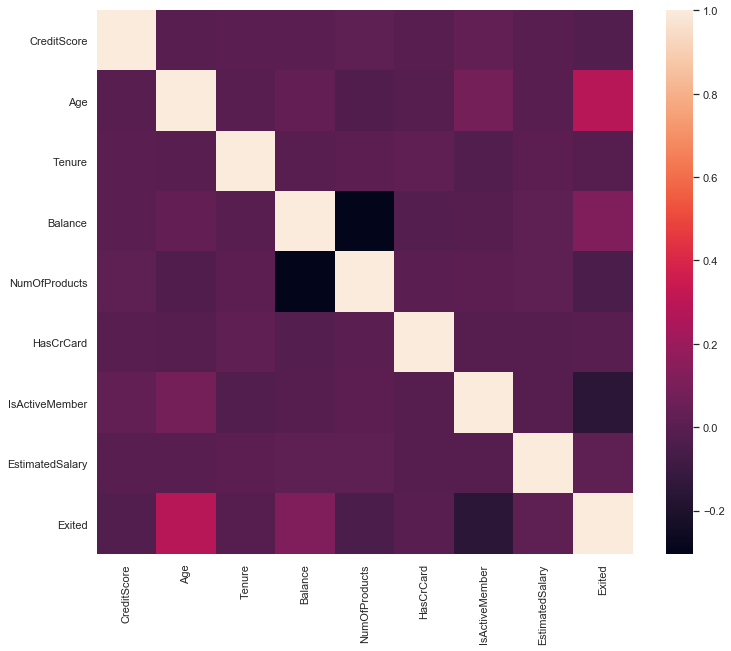

In [16]:
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(data.corr())

Видна слабая обратная зависимость между балансом и кол-вом продуктов банка, используемых клиентами; и слабая прямая зависимость между возрастом и уходом клиента.

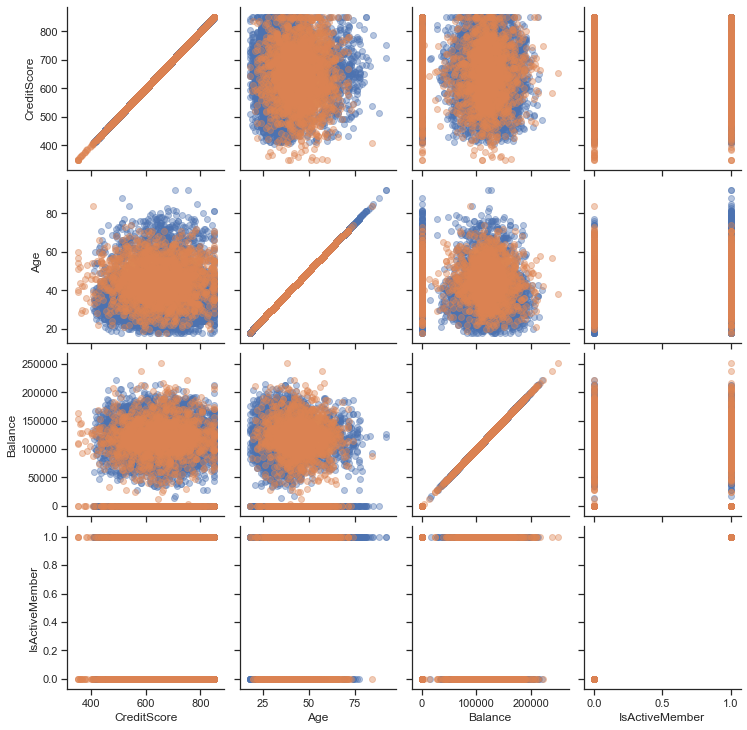

In [17]:
sns.set(style="ticks")
g = sns.PairGrid(data[['CreditScore', 'Age', 'Balance', 'IsActiveMember', 
                       'Exited']], hue='Exited')
g.map(plt.scatter, alpha=0.4)

Сильных линейных зависимостей между признакми не обнаружено.

### Преобразуем признаки в численные методом OHE

In [18]:
data.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                   int8
Tenure                int8
Balance            float64
NumOfProducts         int8
HasCrCard             int8
IsActiveMember        int8
EstimatedSalary    float64
Exited                int8
dtype: object

In [19]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


### Выводы
Данные изучены и подготовлены к дальнешей работе. В ходе подготовки были выполнены следующие действия:
- В столбце Tenure заменили пропуски на нули;
- Изменили тип данных на int8 в следующих столбцах: Tenure, Age, NumOfProducts, HasCrCard, IsActiveMember, Exited;
- Удалили столбцы RowNumber, CustomerId, Surname;
- Провели анализ на мультиколлинеарность факторов, сильной корреляции между признаками не обнаружено;
- Преобразовали категориальные признаки Geography и Gender в численные методом OHE;
- Отмасштабировали количественные признаки CreditScore, Age, Tenure, Balance, EstimatedSalary, NumOfProducts

<a id='2'></a>
# 2. Исследование задачи
[в начало](#0)

### Разбиение датасета

Сохраним значение random_state в переменную rs, для того чтобы каждый раз использовать одно и то же значение

In [21]:
# establishing random_state
rs=33

Разделим датасет на выборки:
- Обучающая 60%
- Валидационная 20%
- Тестовая 20%

In [22]:
# defining features and target 
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

# splitting dataset to train, valid and test
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=rs)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=rs)

#checking the shape
print(features_train.shape)
print(features_test.shape)
print(features_valid.shape)

(6000, 11)
(2000, 11)
(2000, 11)


### Масштабируем признаки
Разброс признаков отличается и чтобы модель правильно обучилась, приведем признаки к единому масштабу

In [23]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts']

scaler = StandardScaler()
features_train[numeric] = scaler.fit(features_train[numeric]).transform(features_train[numeric])

features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_test.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5672,-0.318298,-0.955350,-1.454809,-1.231128,0.818208,1,0,1.633956,0,0,1
3346,0.665947,2.290459,-0.168458,0.978816,-0.902524,0,1,1.154780,0,0,1
5867,-0.235414,2.194994,-0.490046,1.064347,0.818208,1,1,0.745996,1,0,1
2322,-0.857043,0.190230,-1.133222,-1.231128,0.818208,1,0,-1.676361,0,1,0
5233,0.842075,0.953950,-0.168458,0.190494,-0.902524,1,1,-1.150153,1,0,0


### Баланс классов

Оценим насколько сбалансрованны классы

In [24]:
data_ohe['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Наблюдается дисбаланс классов, только 20% положительных ответов. Создадим константную модель `target_pred_constant`, чтобы позже проверить модель на адекватность. 

In [25]:
target_pred_constant = pd.Series([1]*len(target))
print('f1 константной модели', f1_score(target, target_pred_constant))
print('roc_auc константной модели', roc_auc_score(target, target_pred_constant))

f1 константной модели 0.3384564260197724
roc_auc константной модели 0.5


Если модель будет предсказывать лучше этих показателей, то уже лучше, чем без модели

### Логистическая регрессия без учета дисбаланса

Обучим модель логистической регрессии без учета дисбаланса и без настройки гиперпараметров и проверим метрики accuracy, F1-score, AUC-ROC. Первой моделью выберем логистическую регрессию - потому что это просто и быстро покажет проблемы с данными, если они есть.

In [26]:
# make dictionary for models
d = {
    'LogisticRegression': LogisticRegression,
    'DecisionTree': DecisionTreeClassifier,
    'RandomForest': RandomForestClassifier
}

In [27]:
print_score(LogisticRegression, 'LogisticRegression', features_train, target_train)

LogisticRegression:
F1-score: 0.364, AUC-ROC: 0.61


### Выводы
Пока модель работает плохо и показывает результат хуже константной, что может говорить о том, что есть проблема с данными. Попробуем исправить ситуацию с дисбалансом и проверим метрики еще раз.

<a id='3'></a>
# 3. Борьба с дисбалансом
[в начало](#0)

Придадим вес классам и посмотрим на результаты моделей логистической регрессии, дерева решений и случайного леса.

In [28]:
for i in ['LogisticRegression', 'DecisionTree', 'RandomForest']:
    print_score(d[i], i, features_train, target_train, class_weight='balanced')
    print()

LogisticRegression:
F1-score: 0.499, AUC-ROC: 0.71

DecisionTree:
F1-score: 0.524, AUC-ROC: 0.70

RandomForest:
F1-score: 0.591, AUC-ROC: 0.72



f1 метрика логистической регрессии уже выглядит намного лучше. Попробуем улучшить эту метрику, решая проблему дисбаланса с помощью upsampling и downsampling.

In [29]:
features_train.shape

(6000, 11)

проведем upsampling и downsampling и проверим размер увеличинной и уменьшенной выборки

In [30]:
features_upsampled, target_upsampled = upsampling(features_train, target_train, 4)
print('features_upsampled shape:', features_upsampled.shape)

features_downsampled, target_downsampled = downsampling(features_train, target_train, 0.25)
print('features_downsampled shape:', features_downsampled.shape)

features_upsampled shape: (9696, 11)
features_downsampled shape: (2424, 11)


Upsampled

In [31]:
for i in ['LogisticRegression', 'DecisionTree', 'RandomForest']:
    print_score(d[i], i, features_upsampled, target_upsampled, class_weight='balanced')
    print()

LogisticRegression:
F1-score: 0.499, AUC-ROC: 0.71

DecisionTree:
F1-score: 0.537, AUC-ROC: 0.71

RandomForest:
F1-score: 0.624, AUC-ROC: 0.75



Downsampled

In [32]:
for i in ['LogisticRegression', 'DecisionTree', 'RandomForest']:
    print_score(d[i], i, features_downsampled, target_downsampled, class_weight='balanced')
    print()

LogisticRegression:
F1-score: 0.497, AUC-ROC: 0.71

DecisionTree:
F1-score: 0.489, AUC-ROC: 0.70

RandomForest:
F1-score: 0.590, AUC-ROC: 0.78



upsampling и downsampling не повлияли особо на результат, небольшое улучшение метрик наблюдается только у случайного леса.

### Настройка гиперпараметров

#### LogisticRegression

In [33]:
LR_param_grid = {
    'solver': ['sag', 'saga', 'liblinear', 'newton-cg', 'lbfgs']
}

print_GridSearchCV(LogisticRegression, LR_param_grid, features_train, target_train, class_weight='balanced')

best parameter: {'solver': 'liblinear'} f1: 0.50
best parameter: {'solver': 'saga'} roc_auc: 0.77


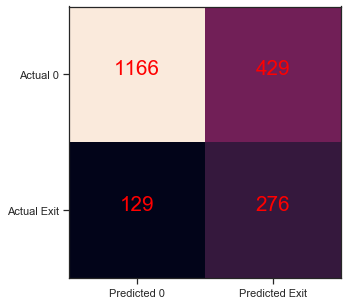

score on valid_data:
f1 score: 0.497
AUC: 0.706


In [34]:
LR_model = LogisticRegression(solver='liblinear', class_weight='balanced')
LR_model.fit(features_downsampled, target_downsampled)
LR_predicted = LR_model.predict(features_valid)
show_cm(LR_model, features_valid, target_valid)
print('score on valid_data:')
print('f1 score: {:.3f}'.format(f1_score(target_valid, LR_predicted)))
print('AUC: {:.3f}'.format(roc_auc_score(target_valid, LR_predicted)))

У логистической регресссии результат все тот же 

#### DecisionTreeClassifier

In [35]:
DT_param_grid = {
    'max_depth': np.arange(1, 11),
    'criterion': ('gini', 'entropy')
}

print_GridSearchCV(DecisionTreeClassifier, DT_param_grid, features_train, target_train)

best parameter: {'criterion': 'entropy', 'max_depth': 7} f1: 0.55
best parameter: {'criterion': 'entropy', 'max_depth': 5} roc_auc: 0.83


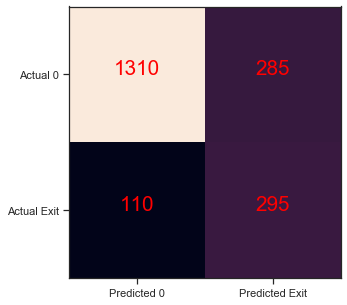

score on valid_data:
f1 score: 0.599
AUC: 0.775


In [36]:
DT_model = DecisionTreeClassifier(criterion='entropy', max_depth=7, class_weight='balanced')
DT_model.fit(features_train, target_train)
DT_predicted = DT_model.predict(features_valid)
show_cm(DT_model, features_valid, target_valid)
print('score on valid_data:')
print('f1 score: {:.3f}'.format(f1_score(target_valid, DT_predicted)))
print('AUC: {:.3f}'.format(roc_auc_score(target_valid, DT_predicted)))

Уже намного лучше

#### RandomForestClassifier

In [37]:
RF_param_grid = {
    'n_estimators': np.arange(11, 51, 10),
    'max_depth': np.arange(1, 11),
    'criterion': ('gini', 'entropy')
}

print_GridSearchCV(RandomForestClassifier, RF_param_grid, 
                   features_train, target_train)

best parameter: {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 41} f1: 0.54
best parameter: {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 41} roc_auc: 0.85


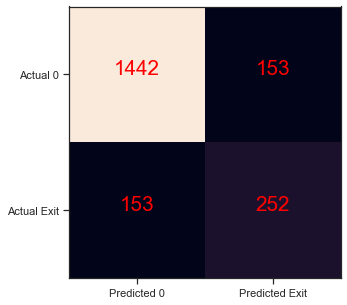

score on valid_data:
f1 score: 0.622
AUC: 0.763


In [38]:
RF_model = RandomForestClassifier(criterion='gini', max_depth=10, 
                                  n_estimators=41, class_weight='balanced')
RF_model.fit(features_train, target_train)
RF_predicted = RF_model.predict(features_valid)
show_cm(RF_model, features_valid, target_valid)
print('score on valid_data:')
print('f1 score: {:.3f}'.format(f1_score(target_valid, RF_predicted)))
print('AUC: {:.3f}'.format(roc_auc_score(target_valid, RF_predicted)))

### Выводы:
После балансировки классов и настройки гиперпараметров лучший результат по метрикам f1-0.62 и AUC-0.78 на валидационной выборке показала модель случайного леса. Но большую полноту признака Exit показала модель дерева решений. Протестируем обе модели на тестовой выборке.

<a id='4'></a>
# 4. Тестирование модели
[в начало](#0)

Перед тем как проверять модель на тестовой выборке, объединим обучающую и валидационную выборки.

In [39]:
features_train_valid = pd.concat([features_train] + [features_valid])
target_train_valid = pd.concat([target_train] + [target_valid])
print(features_train_valid.shape)
target_train_valid.shape

(8000, 11)


(8000,)

### DecisionTreeClassifier

f1 score: 0.572
AUC: 0.756


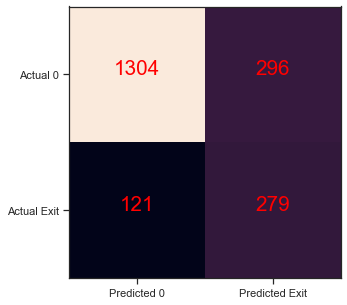

In [40]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=7, class_weight='balanced')
model.fit(features_train_valid, target_train_valid)
predicted = model.predict(features_test)

print('f1 score: {:.3f}'.format(f1_score(target_test, predicted)))
print('AUC: {:.3f}'.format(roc_auc_score(target_test, predicted)))

show_cm(model, features_test, target_test)

### RandomForestClassifier

f1 score: 0.609
AUC: 0.767


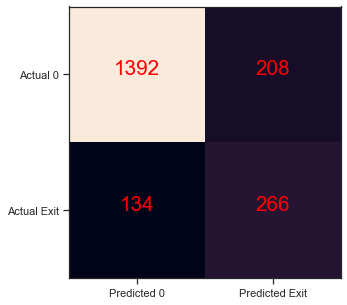

In [41]:
model = RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=41, class_weight='balanced')
model.fit(features_train_valid, target_train_valid)
predicted = model.predict(features_test)

print('f1 score: {:.3f}'.format(f1_score(target_test, predicted)))
print('AUC: {:.3f}'.format(roc_auc_score(target_test, predicted)))

show_cm(model, features_test, target_test)

### Выводы:
- Подоготовили данные для обучения (все признаки привели к численным и к единому масштабу)
- Модель логистической регрессии показывает плохие результаты на несбалансированных данных
- Сравнили модели логистической регрессии, дерева решений и случайного леса с настроиными гиперпараметрами и на сбалансированных данных
- Достигли лучшего результа метрики f1-score 0.617 с помощью модели случайного леса, при этом AUC-ROC 0.77